In [2]:

# LR 4
# Classification task based on X-ray chest images
# CNN
# ['COVID19', 'NORMAL', 'PNEUMONIA']

In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.image import imread
import os
import random
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout,  Flatten, Dense,MaxPool2D
 #for explainable
from skimage.segmentation import mark_boundaries

#from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from tensorflow.keras.metrics import AUC
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.optimizers import SGD, Adam, Adamax
from tensorflow.keras import Model
import tensorflow as tf

In [4]:
train_path = "Data/train/"
test_path = "Data/test/"

os.listdir(train_path)


['COVID19', 'NORMAL', 'PNEUMONIA']

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [6]:
image_size = (224,224,3)

model = Sequential()
model.add(Conv2D(64,(3,3),activation = "relu", input_shape = image_size))
model.add(MaxPool2D())

model.add(Conv2D( 128, (3,3), activation = "relu"))
model.add(MaxPool2D())
model.add(Dropout(0.2))

model.add(Conv2D( 256,(3,3), activation = "relu"))
model.add(MaxPool2D())
model.add(Dropout(0.2))

model.add(Conv2D( 512,(3,3), activation = "relu"))
model.add(MaxPool2D())
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.15))

model.add(Dense(3, activation = "softmax"))


model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 54, 54, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 256)       2

In [7]:
#keras.utils.plot_model(model,show_shapes=True)
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [9]:
history = model.fit(training_set, validation_data=test_set,steps_per_epoch=130,epochs=20)

Epoch 1/20
130/130 [==============================] - 271s 2s/step - loss: 0.7162 - accuracy: 0.7101 - val_loss: 0.6530 - val_accuracy: 0.6444
Epoch 2/20
130/130 [==============================] - 323s 2s/step - loss: 0.4702 - accuracy: 0.8183 - val_loss: 0.3753 - val_accuracy: 0.8804
Epoch 3/20
130/130 [==============================] - 382s 3s/step - loss: 0.4153 - accuracy: 0.8447 - val_loss: 0.2485 - val_accuracy: 0.9138
Epoch 4/20
130/130 [==============================] - 346s 3s/step - loss: 0.4118 - accuracy: 0.8433 - val_loss: 0.3685 - val_accuracy: 0.8898
Epoch 5/20
130/130 [==============================] - 334s 3s/step - loss: 0.3673 - accuracy: 0.8510 - val_loss: 0.2518 - val_accuracy: 0.9053
Epoch 6/20
130/130 [==============================] - 363s 3s/step - loss: 0.3474 - accuracy: 0.8639 - val_loss: 0.2280 - val_accuracy: 0.9146
Epoch 7/20
130/130 [==============================] - 336s 3s/step - loss: 0.3297 - accuracy: 0.8731 - val_loss: 0.2584 - val_accuracy: 0.8991

In [10]:
print("training_accuracy", history.history['accuracy'][-1])
print("validation_accuracy", history.history['val_accuracy'][-1])

training_accuracy 0.9254807829856873
validation_accuracy 0.9324533939361572


<Axes: >

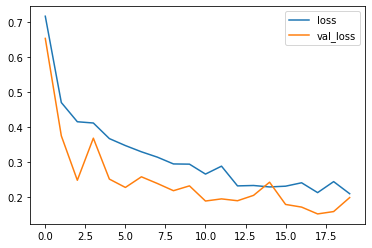

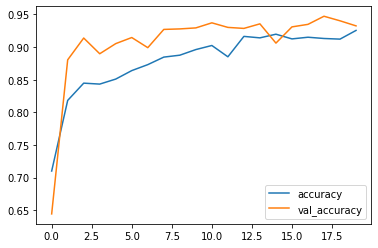

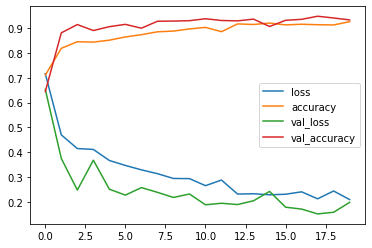

In [11]:
losses = pd.DataFrame(history.history)
losses.head()
losses[['loss','val_loss']].plot() 
losses[['accuracy','val_accuracy']].plot() 
losses.plot()

81/81 [==============================] - 45s 545ms/step


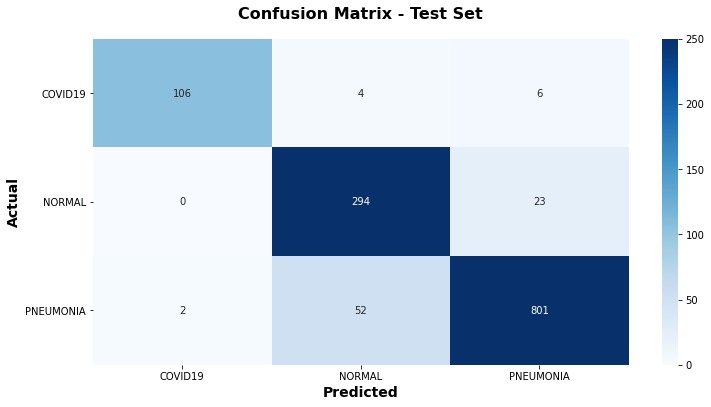

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


classes = ["COVID19", "NORMAL", "PNEUMONIA"]

y_pred = model.predict(test_set)
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_set.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [13]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.98      0.91      0.95       116
           1       0.84      0.93      0.88       317
           2       0.97      0.94      0.95       855

    accuracy                           0.93      1288
   macro avg       0.93      0.93      0.93      1288
weighted avg       0.94      0.93      0.93      1288

